# DATA 255 Team 1 -- Stock Price Prediction (LSTM)
In this project, we performed stock price prediction on Apple's stock 7 days in advance using Recurrent Neural Network. The network architecture is LSTM.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2020-12-05 21:49:55--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv.1’

all_stocks_5yr.csv. 100%[===================>]  28.21M  68.1MB/s    in 0.4s    

2020-12-05 21:49:56 (68.1 MB/s) - ‘all_stocks_5yr.csv.1’ saved [29580549/29580549]



## Data Exploration and Visualization

In [ ]:
# load the data
data = pd.read_csv('./all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
# check basic info of the dataset: size, missing values, data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
# check for duplicates - none
data.duplicated().sum()

0

In [ ]:
# check for missing values
data.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [ ]:
# check how many stocks are included in the dataset
data['Name'].nunique()

505

In [ ]:
# check number of dates included in the dataset
data['date'].nunique()

1259

In [ ]:
# check range of dates
print('earliest date: ', min(data['date']))
print('latest date: ', max(data['date']))

earliest date:  2013-02-08
latest date:  2018-02-07


In [ ]:
# not all stocks have data for each date in the above date range
data['Name'].value_counts()

MSI     1259
BAX     1259
V       1259
HRS     1259
GIS     1259
        ... 
DXC      215
BHGE     152
BHF      143
DWDP     109
APTV      44
Name: Name, Length: 505, dtype: int64

In [ ]:
# check summary statistitics for numeric columns
data.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


Text(0, 0.5, 'Price')

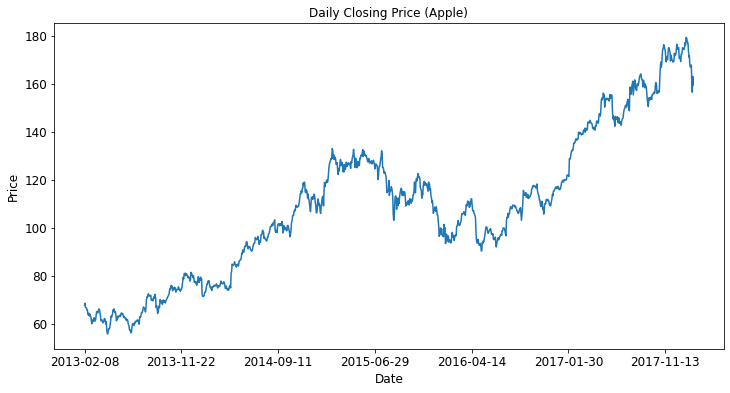

In [ ]:
# plot Apple stock
apple = data[data['Name']=='AAPL']
ax = apple.plot(x='date', y='close', figsize=(12,6), title='Daily Closing Price (Apple)', fontsize=12, legend=False)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

Text(0, 0.5, 'Price')

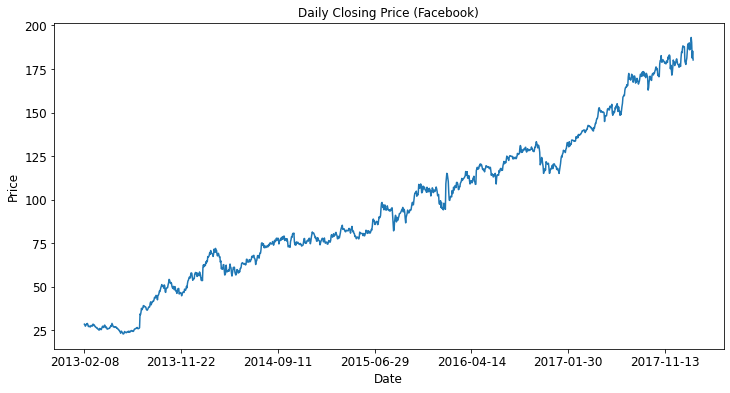

In [ ]:
# plot facebook stock
fb = data[data['Name']=='FB']
ax = fb.plot(x='date', y='close', figsize=(12,6), title='Daily Closing Price (Facebook)', fontsize=12, legend=False)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

Text(0, 0.5, 'Price')

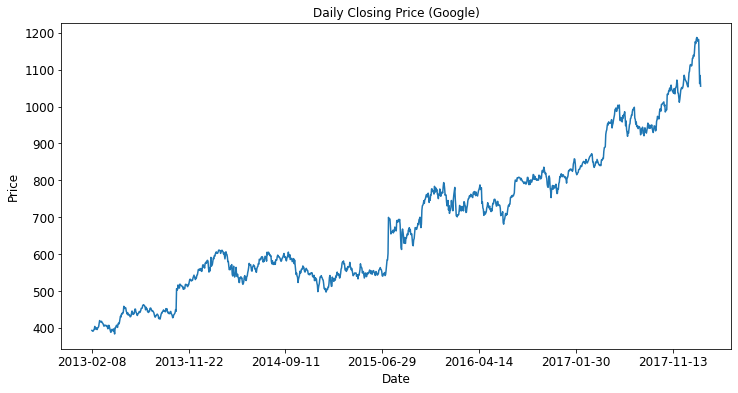

In [ ]:
# plot google stock
google = data[data['Name']=='GOOGL']
ax = google.plot(x='date', y='close', figsize=(12,6), title='Daily Closing Price (Google)', fontsize=12, legend=False)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

## Data Preprocessing

In [ ]:
# extract Apple's stock data from the dataset
dataset = data[data['Name']=='AAPL'].close.values

#### Normalization

In [ ]:
# Data normalization
sc = MinMaxScaler(feature_range = (0, 1))
dataset = dataset.reshape(dataset.shape[0], 1)
dataset_sc = sc.fit_transform(dataset)

#### Cut time series into input/output pairs
Apply a sliding window (window size = 7) to create input/output pairs for the RNN model. The input is a sequence of lenght 7 and output is a scalar value.

In [ ]:
# Define a function to process the data into n day look back slices
def slidingWindow(data, lb):
    X, y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        y.append(data[(i + lb), 0])
    return np.array(X), np.array(y)

In [ ]:
# Process Apple's stock into 7 day look back slices
X, y = slidingWindow(dataset_sc, 7)

#### Train-test split
We'll use the last 1/5 of this time series data for validation.


In [ ]:
# train test split
X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]
print('X_train:', X_train.shape[0])
print('X_test:', X_test.shape[0])
print('y_train:', y_train.shape[0])
print('y_test:', y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train: 1000
X_test: 251
y_train: 1000
y_test: 251


## Model Training and Evaluation
We will first build a LSTM model, then two other time series models (rolling average & ARIMA) to compare prediction results.

### LSTM Model
We built an RNN model with 2 hidden layers:
- First layer uses LSTM module with 64 hidden units
- Second layer uses fully connected module with 1 unit

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN_model, self).__init__()
        self.num_directions = bidirectional + 1
        self.rnn = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional)
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [ ]:
# specify global parameters
input_size = 7
hidden_size = 64
num_layers = 3
output_size = 1
batch_size = 128

# specify hyperparameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN_model(input_size, hidden_size, num_layers, output_size, bidirectional=False)
# change colab runtime type to GPU
rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# use mean squared error loss
criterion = nn.MSELoss()
hidden_state = None

rnn

RNN_model(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
history = []
X_train_cuda = torch.tensor(X_train).float().cuda()
y_train_cuda = torch.tensor(y_train).float().cuda()
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(X_train_cuda, hidden_state) 
    loss = criterion(output[:,0,:].view(-1), y_train_cuda)
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update the parameters
    optimizer.step()                    
    
    rnn.eval()
    test_output, _ = rnn(X_test_cuda, hidden_state)
    test_loss = criterion(test_output.view(-1), y_test_cuda)
    print('epoch {}, train_loss {}, val_loss {}'.format(epoch, loss.item(), test_loss.item()))
    history.append(loss.item())

epoch 0, train_loss 0.22644303739070892, val_loss 0.7887001037597656
epoch 1, train_loss 0.1996956318616867, val_loss 0.7338616251945496
epoch 2, train_loss 0.17554664611816406, val_loss 0.6803891062736511
epoch 3, train_loss 0.1525246948003769, val_loss 0.6266449093818665
epoch 4, train_loss 0.13081882894039154, val_loss 0.5710315704345703
epoch 5, train_loss 0.10939427465200424, val_loss 0.5120203495025635
epoch 6, train_loss 0.0889427587389946, val_loss 0.4480733871459961
epoch 7, train_loss 0.06922175735235214, val_loss 0.3777681887149811
epoch 8, train_loss 0.05050840973854065, val_loss 0.3002183437347412
epoch 9, train_loss 0.034657157957553864, val_loss 0.2164197564125061
epoch 10, train_loss 0.02452394925057888, val_loss 0.13326644897460938
epoch 11, train_loss 0.024531949311494827, val_loss 0.07318009436130524
epoch 12, train_loss 0.03685539588332176, val_loss 0.05383896455168724
epoch 13, train_loss 0.044234927743673325, val_loss 0.05858626589179039
epoch 14, train_loss 0.041

In [ ]:
rnn.out.weight 

Parameter containing:
tensor([[-0.0631, -0.0360,  0.0675, -0.1025, -0.0875,  0.0531, -0.0274, -0.0595,
          0.0048, -0.1007, -0.0958,  0.0103, -0.0291,  0.0519,  0.0353, -0.0277,
         -0.0536,  0.0217, -0.1061,  0.1254,  0.0495,  0.0815,  0.0145, -0.0076,
         -0.0866, -0.0677, -0.0992,  0.1286,  0.1037,  0.1230, -0.0050, -0.0751,
         -0.0318,  0.1218, -0.0296,  0.0759,  0.1067,  0.0767, -0.0825,  0.0242,
          0.1240,  0.0360, -0.0276, -0.0487,  0.0272,  0.1064, -0.0028,  0.0328,
          0.0661, -0.0217, -0.1066, -0.0472, -0.1155, -0.0948,  0.1119, -0.0040,
         -0.1034, -0.0211, -0.0105,  0.0703,  0.0681,  0.0112,  0.1128, -0.0478]],
       device='cuda:0', requires_grad=True)

#### Check LSTM model performance

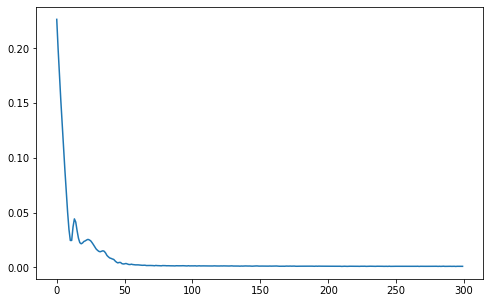

In [ ]:
# plot mean squared error loss
plt.figure(figsize=(8,5))
plt.plot(history, )

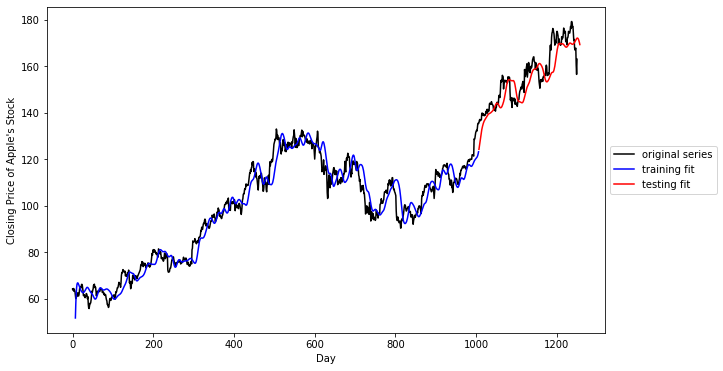

In [ ]:
# plot original data
plt.figure(figsize=(10,6))
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

train_pred, hidden_state = rnn(X_train_cuda, None)
# use hidden state from previous training data
test_pred, _ = rnn(X_test_cuda, hidden_state)
train_pred_cpu = train_pred.cpu().detach().numpy()
test_pred_cpu = test_pred.cpu().detach().numpy()

split_loc = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_loc, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_loc, split_loc + len(test_pred_cpu), 1), sc.inverse_transform(test_pred_cpu.reshape(-1,1)), color='r')

# label the graph properly
plt.xlabel('Day')
plt.ylabel("Closing Price of Apple's Stock")
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))

### Build Time Series Models
- Rolling Average
- ARIMA

In [ ]:
# use rolling average 
y_ra = X_test.mean(axis=2).flatten()
y_ra.shape

(251,)

In [ ]:
# we use ARIMA model that doesn't need training, so we directly fit it on X_test and y_test
dftest = adfuller(y_test, autolag='AIC')
print(dftest[1])

0.438884393816877


In [ ]:
# based on the above ADF prediction score, our series is stationary, so we can proceed with time series fitting
model = ARIMA(X_test[:,0,-1], order=(2, 2, 2))  
results_AR = model.fit(disp=-1)  
final_prediction = results_AR.fittedvalues + y_ra[0:-2]  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


### Compare Model Performance

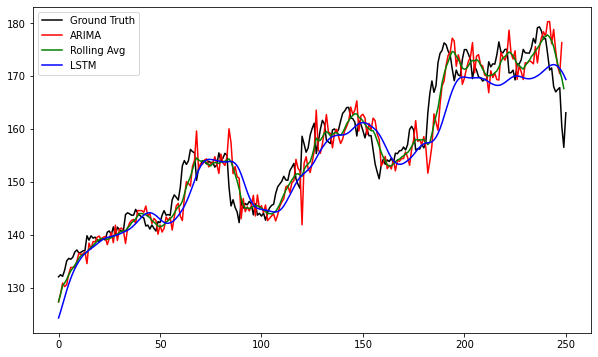

In [ ]:
# plot predictions from 3 models along with the ground truth
plt.figure(figsize=(10,6))
plt.plot(sc.inverse_transform(y_test[0:].reshape(-1,1)), color='black', label='Ground Truth')
plt.plot(sc.inverse_transform(final_prediction.reshape(-1,1)), color='red', label='ARIMA')
plt.plot(sc.inverse_transform(y_ra[0:-1].reshape(-1,1)), color='green', label='Rolling Avg')
plt.plot(sc.inverse_transform(test_pred_cpu.reshape(-1,1)), color='blue', label='LSTM')
plt.legend()

In [ ]:
# compare mean squared error for 3 models
# rolling average
a = (y_ra - y_test)**2
a = a.mean()

# ARIMA
b = (final_prediction - y_test[0:-2])**2
b = b.mean()

print("Rolling Avg MSE loss: %f" %(a))
print("ARIMA model MSE loss: %f" %(b))
print("LSTM model MSE loss: %f" %(test_loss.item()))

Rolling Avg MSE loss: 0.000659
ARIMA model MSE loss: 0.001230
LSTM model MSE loss: 0.005382
